# Calibration notebook
Enter with the path of images using for calibration.

Use three collinear markers

## Global definitions

In [47]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.io import savemat
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import os,shutil
import pandas as pd

## Import and match csv

In [48]:
def checkDatasets(dfCam1,dfCam2):
    if len(dfCam1) < len(dfCam2):                       
        minLength = len(dfCam1)
        columnsName = ['cam1', 'cam2','diff','imgDiff1','imgDiff2']
    else:  # swap data frames if the first is longer
        df_aux = dfCam1; dfCam1 = dfCam2
        dfCam2 = df_aux; del df_aux
        minLength = len(dfCam1)
        columnsName = ['cam2', 'cam1','diff','imgDiff1','imgDiff2']
    return dfCam1,dfCam2,columnsName,minLength

def removeAssync(df,tresh,windowLength,colName):
    # create arrays  
    diffArray = np.hstack((0,np.diff(df[colName]))) 
    removeIdx = np.array([0])   
    # plot sync results    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(df[colName],linewidth=3.0,label='absolute value')
    plt.plot(diffArray,linewidth=3.0,label='diff')
    plt.grid()
    plt.legend()
    plt.xlabel("# of images")
    plt.ylabel("Image # difference for "+colName)
    plt.xlim(0,len(diffArray))    
    # search for assync points
    for i in range(0,len(diffArray)):
        diff = diffArray[i]
        if abs(diff) > tresh: 
            if i+windowLength >= len(diffArray):
                windowLength = len(diffArray)-i
            # if diff > thresh, discard a window arround it  
            window = np.arange(0,windowLength)+i
            plt.axvline(x=i, color='r', linestyle='--')    
            plt.axvline(x=i+windowLength, color='g', linestyle='--')
            removeIdx = np.hstack((removeIdx,window))
    # drop elements from df
    if removeIdx.shape[0] != 1:
        removeIdx = np.unique(removeIdx[1:],0)
    print('>> '+colName+': Removed '+str(len(removeIdx))+' images because of assync image count')

    return removeIdx

def matchDatasets(dfCam1,dfCam2,columnsName,minLength,maxDiff,tresh,windowLength):    
    df = pd.DataFrame(columns = columnsName)  # create empty dataframe
    for i in range(0,minLength):
        # collect time difference 
        timeCam1 = dfCam1['ts'][i]
        dfCam2_valid = dfCam2['ts'].to_numpy()
        diff = np.abs(dfCam2_valid-timeCam1)/(10**9)
        # find the smallest difference
        j = np.argmin(diff)
        inUse = df[df[columnsName[1]] == j]['diff']
        if inUse.any():
            # compare if diff is less than the reported at the table                 
            compareArray = np.array([diff[j],inUse.item()])
            minArray = np.argmin(compareArray)
            if minArray: 
                continue
            # if smallest if the new line, drop the wrong line     
            df = df.drop(labels=inUse.index.to_numpy()[0], axis=0)
        df.loc[len(df)] = [i,j,diff[j],0,0] 
        if i % 1000 == 0: # tracking images processed
            print("Finished image "+ str(i))
    print('>> '+str(len(df))+' images matched')
    # selecting valid rows        
    df['valid'] = df['diff'] < maxDiff
    df.to_csv('artSync.csv')  
    invalidRows = df.loc[df['valid'] == False].index.to_numpy()   
    print('>> Removed '+str(len(invalidRows))+' images because of assync derivatives') 
    # selecting rows to exclude after matching       
    df['imgDiff1'] = np.hstack((0,np.diff(df['cam1']))) 
    df['imgDiff2'] = np.hstack((0,np.diff(df['cam2'])))  
    removeIdx1 = removeAssync(df,tresh,windowLength,'imgDiff1')
    removeIdx2 = removeAssync(df,tresh,windowLength,'imgDiff2')
    df.loc[removeIdx1,'valid'] = False
    df.loc[removeIdx2,'valid'] = False
    # ploting and returning variables
    removeIdx = np.unique(np.concatenate((removeIdx1,removeIdx2,invalidRows),0))
    print('Time artifical sync: '+ str(len(df.loc[df['valid'] == True].index.to_numpy()))+'/'+
            str(minLength)+' images are valid')  
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(df['diff'][df.loc[df['valid'] == True].index.to_numpy()],linewidth=3.0,label='absolute value')
    plt.grid()
    plt.legend()
    plt.xlabel("# of images")
    plt.ylabel("Delay between cameras (s)")
    plt.xlim(0,len(df.loc[df['valid'] == True].index.to_numpy()))
    #select each camera valid row
    cam1_rows = df['cam1'].to_numpy().astype(int)
    cam2_rows = df['cam2'].to_numpy().astype(int)  
    return cam1_rows,cam2_rows,removeIdx

## Undistort

In [49]:
def myUndistortPointsPinhole(pts, cameraMatrix, distCoef):
    # remove destortion
    undPt_norm = cv2.undistortPoints(pts, cameraMatrix, distCoef).reshape(-1,2)
    # remove normalization
    undPt = cameraMatrix_cam1@np.hstack((undPt_norm,np.ones((undPt_norm.shape[0],1)))).T
    undPt = undPt[0:2,:].T

    return undPt

def myUndistortPointsFisheye(pts,K,D):
    # save variables
    pts = pts.reshape(-1,1,2)
    fx = K[0,0]
    fy = K[1,1]
    cx = K[0,2]
    cy = K[1,2]
    # remove destortion
    undPts_norm = cv2.fisheye.undistortPoints(pts, K, D)
    undPts_norm = undPts_norm.reshape(-1,2)
    # remove normalization
    undistPts= np.zeros_like(undPts_norm)
    for i, (x, y) in enumerate(undPts_norm):
        px = x*fx + cx
        py = y*fy + cy
        undistPts[i,0] = px
        undistPts[i,1] = py    
    return undistPts

## Segmentation

In [50]:
def highTreshSeg(imgName,bg,camNumber):
    #define tresh for different cameras
    if camNumber == 1:
        threshValue = 127
    else:
        threshValue = 127
    # read image and apply high threshold filter
    imgBG = cv2.imread(bg, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(imgName, cv2.IMREAD_GRAYSCALE) 
    imgMarkers = cv2.subtract(img, imgBG)       
    _, imgThresh = cv2.threshold(imgMarkers,threshValue, 255, cv2.THRESH_BINARY)  

    boxMargin = 5 # box margin from markers
    
    # navigate image and find extreme markers   
    nonNullCoord = np.array(np.nonzero(imgThresh))
    if nonNullCoord.size == 0:
        return 0, [0,0], [0,0]
    coordFirst = [nonNullCoord[0].min(),nonNullCoord[1].min()]
    coordLast = [nonNullCoord[0].max(),nonNullCoord[1].max()]

    # add margins and flip vector from Y,X to X,Y
    coordFirst = np.flip(np.add(coordFirst,[-boxMargin,-boxMargin]))
    coordLast  = np.flip(np.add(coordLast,[boxMargin,boxMargin]))

    # plot image with rectangle mask
    '''imgPlot = cv2.cvtColor(imgThresh,cv2.COLOR_GRAY2RGB)
    imgPlot = cv2.rectangle(imgPlot,coordFirst,coordLast,(0,255,0),2)
    plt.figure(figsize=(10, 6), dpi=100)
    plt.axis('off')
    plt.imshow(imgPlot, cmap='gray') '''   

    return 1, coordFirst, coordLast

In [51]:
def lowTreshSeg(imgName,bg,camNumber):

    # get rectangle mask for boundary
    val, coordFirst, coordLast = highTreshSeg(imgName,bg,camNumber)
    
    if val:
    # read image and apply high rectangle mask
        imgBG = cv2.imread(bg, cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(imgName, cv2.IMREAD_GRAYSCALE)  
        imgMarkers = cv2.subtract(img, imgBG)     
        imgMask = np.zeros_like(img)
        imgMask = cv2.rectangle(imgMask,coordFirst,coordLast,(1,1,1),-1)
        imgMasked = imgMask*imgMarkers 
        '''plt.figure(figsize=(10, 6), dpi=100)
        plt.imshow(imgMasked, cmap='gray')'''

        if verbose == 1:
            newName = imgName.replace('raw', 'postProcessing', 1)   # get new folder
            cv2.imwrite(newName, imgMasked)                         # write processed image
    return val,imgMasked


## Centroid extraction

In [52]:
def isCollinear(p0, p1, p2):
    X = [[p0[0]], [p1[0]], [p2[0]]]             # X coordinated of all centers
    y = [p0[1], p1[1], p2[1]]                   # Y coordinated of all centers
    
    reg = linear_model.LinearRegression()       # create LS model
    reg.fit(X, y)                               # fit model
    
    a3 = reg.coef_                              # get line coeficient A
    b3 = reg.intercept_                         # get line coeficient B

    y0_LS = abs(int(a3*p0[0] + b3 - p0[1]))     # find residual between y and 
    y1_LS = abs(int(a3*p1[0] + b3 - p1[1]))     # the coordinates Y on the LS line
    y2_LS = abs(int(a3*p2[0] + b3 - p2[1]))
    
    m = (y0_LS + y1_LS + y2_LS)/3               # get mean value of error

    # if it is less than 1 pixel, they are collinear
    res = (m < 1)

    return res

In [53]:
def findBlobsCenter(imgName,imgMasked,cameraMatrix,distCoef,useFisheye):
    # read image
    #newName = imgName.replace('raw', 'postProcessing', 1)
    imgMasked = cv2.bitwise_not(imgMasked) 
    centerCoord = np.zeros((3,2)) 
    valid = False

    # configure blob detector
    params = cv2.SimpleBlobDetector_Params()  
    params.minThreshold = 0    
    params.thresholdStep = 1
    params.maxThreshold = 200
    params.filterByArea = True
    params.minArea = 2
    params.filterByConvexity = True
    params.minConvexity = 1
    params.minDistBetweenBlobs = 0
    params.filterByColor = True
    params.blobColor = 0
    params.minRepeatability = 20

    # detect blobs
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(imgMasked)

    '''imgWithKPts = cv2.drawKeypoints(imgMasked, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    imgWithKPts = cv2.cvtColor(imgMasked, cv2.COLOR_GRAY2BGR) 
    bitsShift = 4
    constMultiplier = 16
    for keyPt in keypoints:
        center = (int(np.round(keyPt.pt[0]*constMultiplier)), int(np.round(keyPt.pt[1]*constMultiplier)))
        radius = int(np.round(keyPt.size/2*constMultiplier))
        imgWithKPts = cv2.circle(imgWithKPts, center, radius, (255,0,0), thickness = 1, lineType = 16, shift = bitsShift)
        cv2.circle(imgWithKPts, center, 1, (255, 255, 255), -1,  shift = bitsShift)         
    cv2.putText(imgWithKPts, '# centroids = '+str(len(keypoints)), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)  
    plt.figure(figsize=(10, 6), dpi=300)
    plt.imshow(imgWithKPts, cmap='gray')'''

    # discard if not 3 blobs are recognized
    if np.array(keypoints).shape[0] < 3: # discard
        print('Number of blobs in ' + imgName + ' is ' + str(np.array(keypoints).shape[0])+'. Discarded. ')         
        return centerCoord, valid
    elif np.array(keypoints).shape[0] > 3: # get threee bigger blobs
        diameter = []
        for keyPt in keypoints:
            diameter.append(keyPt.size)
        orderAscDiameters = np.flip(np.argsort(diameter))
        keypoints = [keypoints[orderAscDiameters[0]],keypoints[orderAscDiameters[1]],keypoints[orderAscDiameters[2]]]

    # find blobs' center
    valid = True
    for i in range(0,3):
        centerCoord[i] = [keypoints[i].pt[0],keypoints[i].pt[1]]
    
    # undistort
    if useFisheye:
        undPt = myUndistortPointsFisheye(np.array(centerCoord), cameraMatrix, distCoef)
    else:
        undPt = myUndistortPointsPinhole(np.array(centerCoord), cameraMatrix, distCoef)

    valid = isCollinear(*undPt)

    return undPt, valid

## Centroid ordering

In [54]:
def swapElements(arr, idx1, idx2):
    aux = arr[idx1]
    arr[idx1] = arr[idx2]
    arr[idx2] = aux
    return arr

In [55]:
def getSignal(num1, num2, tol=10**6):
    if abs(num1-num2) <= tol:
        return 0,False
    if (num1-num2) < 0:
        return -1,True
    else:
        return 1,True

In [56]:
def reshapeCoord(coord):
    # first reshape array of coordinates
    coordCopy = np.array(coord).reshape(6)
    # get the Y coordinates of each markers' center
    coordX = [coordCopy[0], coordCopy[2], coordCopy[4]]
    coordY = [coordCopy[1], coordCopy[3], coordCopy[5]]
    return coordX,coordY

In [57]:
def findNearestC(nearestA, nearestB): # get the numer missing from the array [0,1,2]
    vec = np.array([nearestA, nearestB])
    is0, = np.where(vec == 0)
    is1, = np.where(vec == 1)
    is0 = len(is0)
    is1 = len(is1)
    if is0:
        if is1:
            return 2
        else:
            return 1
    else:
        return 0

In [58]:
def getOrder(centerX,centerY, baseAxis=False, axis = 1):
    # get wand direction
    distY = np.array(centerY).max() - np.array(centerY).min()
    distX = np.array(centerX).max() - np.array(centerX).min()   
    # define the order of the markers 
    if not baseAxis:  #if there is no axis to compare, get maximum dist
        if distY > distX:
            order = np.argsort(centerY)
            axis = 1
        else:
            order = np.argsort(centerX)
            axis = 0
    else:  # if there is a previous frame, compare to its axis
        if axis:
            order = np.argsort(centerY)
        else:
            order = np.argsort(centerX)

    return order, axis


In [59]:
def orderCenterCoord(centerCoord, prevCenterCoord, map1, map2, otherCamOrder = 0, imgName='', verbose = 0):
    centerX, centerY = reshapeCoord(centerCoord)

    # if it is the first image of the sequence
    if len(prevCenterCoord) == 0:  
        order,_ =  getOrder(centerX,centerY)         

        # if it is the second camera
        if otherCamOrder != 0:  
            # if the markers are wrong, swap the extremities
            signal, valid = getSignal(centerY[order[0]], centerY[order[2]],5)
            if signal != otherCamOrder and valid:
                order = swapElements(order, 0, 2)    
        else:        
            # get base for comparision (first camera only)        
            otherCamOrder,_ = getSignal(centerY[order[0]], centerY[order[2]])

        # sort centers        
        sortedCenterCoord = np.array((centerCoord[order[0]], centerCoord[order[1]], centerCoord[order[2]]))
    else:
        # first reshape array of coordinates
        prevCenterX,prevCenterY = reshapeCoord(prevCenterCoord)

        # distance from marker A/B of previous img to center coordiantes of actual img
        distA = np.sqrt(np.power(np.subtract(prevCenterX[0], centerX), 2) + np.power(np.subtract(prevCenterY[0], centerY), 2))
        distB = np.sqrt(np.power(np.subtract(prevCenterX[1], centerX), 2) + np.power(np.subtract(prevCenterY[1], centerY), 2))

        # nearest marker from A is selected and removed as marker B candidate
        nearestA = np.argmin(distA)
        distBCopy = np.delete(distB, nearestA)
        # nearest marker from B is selected and removed as marker C candidate
        nearestBCopy = np.argmin(distBCopy)
        nearestB, = np.where(distB == distBCopy[nearestBCopy])
        distBCopy = np.delete(distBCopy, nearestBCopy)
        # get the missing marker position in array
        nearestC = findNearestC(nearestA, nearestB[0])

        # sort centers        
        sortedCenterCoord = [centerCoord[nearestA], centerCoord[nearestB[0]], centerCoord[nearestC]]
        # check if the ordering is ok
        centerX, centerY = reshapeCoord(sortedCenterCoord)
        prevOrder,axisPrev = getOrder(prevCenterX,prevCenterY)
        order,_ =  getOrder(centerX,centerY,baseAxis=True,axis=axisPrev)
        if (order[1] != 1) or (order[2] != prevOrder[2]):
            if prevOrder[0] == 2:  #if is decreasing, swap
                order = swapElements(order,0,2)
            sortedCenterCoord = np.array((sortedCenterCoord[order[0]], sortedCenterCoord[order[1]], sortedCenterCoord[order[2]]))
    
    # plotting debbug
    if verbose:
        k = 0
        newName = imgName.replace('raw', 'postProcessing', 1)
        imgMasked = cv2.bitwise_not(cv2.imread(newName, cv2.IMREAD_GRAYSCALE))
        imgWithKPts = cv2.cvtColor(imgMasked, cv2.COLOR_GRAY2BGR) 
        imgWithKPts = cv2.remap(imgWithKPts, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        bitsShift = 4
        constMultiplier = 16
        for coord in sortedCenterCoord:                              # draw markers center and number
            cX = int(np.round(coord[0]*constMultiplier))
            cY = int(np.round(coord[1]*constMultiplier))
            cv2.circle(imgWithKPts, (cX, cY), 1, (255, 255, 255), -1,  shift = bitsShift)
            cv2.putText(imgWithKPts, str(k), (int(cX/16) - 25, int(cY/16) - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            k = k+1       
        #plt.figure(figsize=(10, 6), dpi=300)
        #plt.imshow(imgWithKPts, cmap='gray')  
        newName = newName.replace('postProcessing', 'centroids', 1)
        cv2.imwrite(newName, imgWithKPts)

    return sortedCenterCoord, otherCamOrder

In [60]:
def getPreviousCentroid(noPrevious, lastCentroid):
    if not noPrevious:
        return []
    else:
        return lastCentroid

## Triangulation

In [61]:
def mySVD(E):
    U,Ddiag,V = np.linalg.svd(E)
    D = np.zeros((3, 3))
    np.fill_diagonal(D, Ddiag)
    V = V.T.conj() 
    return U,D,V

def decomposeEssentialMat(E,K1,K2,pts1,pts2):
    U,D,V = mySVD(E)
    e = (D[0][0]+D[1][1])/2
    D = np.diag([e,e,0])
    E_aux = np.matmul(np.matmul(U,D),V.T)
    U,_,V = mySVD(E_aux)
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    Z = [[0,1,0],[-1,0,0],[0,0,0]]
    R1 = np.matmul(np.matmul(U,W),V.T)
    R2 = np.matmul(np.matmul(U,W.T),V.T)

    if np.linalg.det(R1) < 0: R1 = -R1
    if np.linalg.det(R2) < 0: R2 = -R2

    Tx = np.matmul(np.matmul(U,Z),U.T)
    t = np.array([Tx[2][1],Tx[0][2],Tx[1,0]])

    Rs = np.concatenate((R1,R1,R2,R2)).reshape(-1,3,3)
    Ts = np.concatenate((t,-t,t,-t)).reshape(-1,1,3)

    numNegatives = np.zeros((Ts.shape[0],1))
    numPoints = pts1.shape[0]
    P1 = np.hstack((K1,[[0.],[0.],[0.]]))

    for i in range(0,Ts.shape[0]):
        P2 = np.matmul(K2,np.hstack((Rs[i],Ts[i].T)))
        M1 = P1[0:3, 0:3]
        M2 = P2[0:3, 0:3]   
        c1 = np.matmul(-np.linalg.inv(M1),P1[0:3,3])
        c2 = np.matmul(-np.linalg.inv(M2),P2[0:3,3])
        u1 = np.vstack((pts1.T,np.ones((1,numPoints))))
        u2 = np.vstack((pts2.T,np.ones((1,numPoints))))
        y = c2 - c1;
        a1 = np.matmul(np.linalg.inv(M1),u1)
        a2 = np.matmul(np.linalg.inv(M2),u2)
        points3D = np.zeros((numPoints,3))
        for k in range(0,numPoints):
            A = np.hstack((a1[:,k].reshape(3,1),-a2[:,k].reshape(3,1)))
            alpha = np.matmul(np.linalg.pinv(A),y)
            p = (c1 + alpha[0] * a1[:,k] + c2 + alpha[1] * a2[:,k]) / 2
            points3D[k,:] = p
        m1 = points3D
        m2 = np.add(np.matmul(m1,Rs[i].T),np.tile(Ts[i],(numPoints,1)))
        numNegatives[i] = np.sum((m1[:,2] < 0) | (m2[:,2] < 0));

    idx = numNegatives.argmin()
    R = Rs[idx]
    t = Ts[idx]
    #t = np.matmul(-t, R)
    return R,t

def myProjectionPoints(pts):
    projPt = np.zeros((2, len(pts)))
    i = 0
    for [x, y] in pts:
        projPt[0, i] = x
        projPt[1, i] = y
        i = i + 1
    return projPt

In [62]:
def normalisePoints(pts):
    # calculate origin centroid
    center = np.mean(pts,axis=0)
    # translate points to centroid
    traslatedPts = pts - center
    # calculate scale for the average point to be (1,1,1) >> homogeneous
    meanDist2Center = np.mean(np.linalg.norm(traslatedPts,axis=1))
    if meanDist2Center: # protect against division by zero
        scale = np.sqrt(2)/meanDist2Center
    else:
        return pts, 0, False
    
    # compute translation matrix >> (x-x_c)*scale
    T = np.diag((scale,scale,1))
    T[0:2,2] = -scale*center

    # transform in homogeneous coordinates
    homogeneousPts = np.vstack((pts.T,np.ones((1,pts.shape[0]))))
    normPoints = np.matmul(T,homogeneousPts)
    return normPoints, T, True

def erroReprojection(F,pts1,pts2):  # pts are Nx3 array of homogenous coordinates.  
    # how well F satisfies the equation pt1 * F * pt2 == 0
    vals = np.matmul(pts2.T,np.matmul(F,pts1))
    err = np.abs(vals)
    print("avg x'Fx=0:",np.mean(err))
    print("max x'Fx=0:",np.max(err))
    return np.mean(err)

def estimateFundMatrix_8norm(pts1,pts2):
    # get number of matched points
    numPoints = pts1.shape[0]
    # transform to normalized points
    normPts1,t1,valid1 = normalisePoints(pts1) 
    normPts2,t2,valid2 = normalisePoints(pts2)
    if valid1 and valid2:
        # construct A matrix for 8-norm
        # Zisserman (pag 279)
        A = np.zeros((numPoints,9))
        for i in range(numPoints):
            pt1 = normPts1[:,i]
            pt2 = normPts2[:,i]
            A[i] = [pt1[0]*pt2[0], pt1[1]*pt2[0], pt2[0],
                    pt1[0]*pt2[1], pt1[1]*pt2[1], pt2[1],
                           pt1[0],        pt1[1],      1]

        # F is the smallest singular value of A
        _,_,V = mySVD(A)
        F = V[:, -1].reshape(3,3)
        U,D,V = mySVD(F)
        D[-1,-1] = 0
        F = np.matmul(np.matmul(U,D),V.T)

        # transform F back to the original scale
        F = np.matmul(np.matmul(t2.T,F),t1)
        # normalise F
        F = F/np.linalg.norm(F)
        if F[-1,-1] < 0: F = -F
        print("Fund. Mat.\n", F.round(4))
        erroReprojection(F,np.vstack((pts1.T,np.ones((1,pts1.shape[0])))),
                   np.vstack((pts2.T,np.ones((1,pts2.shape[0])))))
        return F,True
    else:
        return 0,False

In [63]:
def cleanFolders():
    paths = ['./postProcessing','./centroids']

    for dir_path in paths:
        try:
            if os.path.isdir(dir_path): shutil.rmtree(dir_path)
            os.makedirs(dir_path+'/camera1')
            os.makedirs(dir_path+'/camera2')
        except OSError as e:
            print("Error: %s : %s" % (dir_path, e.strerror))


## Run section

### Preparing data

In [64]:
# defining intrinsics
useFisheye = True

if useFisheye:
    cameraMatrix_cam1 =np.array([[816.188,0,318.382],
                                [0,814.325,250.263],
                                [0,0,1]])
    distCoef_cam1 = np.array([[-0.292355],[0.199853],[0.386838],[-6.51433]], dtype=np.float32)

    cameraMatrix_cam2 =np.array([[675.551,0,291.424],
                                [0,675.498,282.561],
                                [0,0,1]])
    distCoef_cam2 = np.array([[-0.0817978],[-0.608661],[5.35317],[-14.1123]], dtype=np.float32)
else:
    cameraMatrix_cam1 = np.array([[667.14635566,0., 308.78964047],
                                  [0.,666.76488644,256.08111935],
                                  [0.,0.,1.]])    
    distCoef_cam1 = np.array( [[-5.12981588e+01,6.64055509e+02,-5.75793603e-03,-2.17602855e-03,
                                3.15194859e+02,-5.08522314e+01,6.40920523e+02,6.23170811e+02,
                                0,0,0,0,
                                0,0]], dtype=np.float32)

    cameraMatrix_cam2 = np.array([[673.99850978,0., 298.49577741],
                                  [0.,673.05611368,273.82850552],
                                  [0.,0.,1.]])
    distCoef_cam2 = np.array( [[3.37971292e+01,-3.05123725e+01,-5.64474905e-05,-1.81576256e-03,
                                9.20523981e+01,3.42420986e+01,-1.64136090e+01,8.56366455e+01,
                                0,0,0,0,
                                0,0]], dtype=np.float32)

Finished image 0
Finished image 1000
Finished image 2000
Finished image 3000
Finished image 4000
>> 4801 images matched
>> Removed 0 images because of assync derivatives
>> imgDiff1: Removed 1 images because of assync image count
>> imgDiff2: Removed 1 images because of assync image count
Time artifical sync: 4800/4801 images are valid


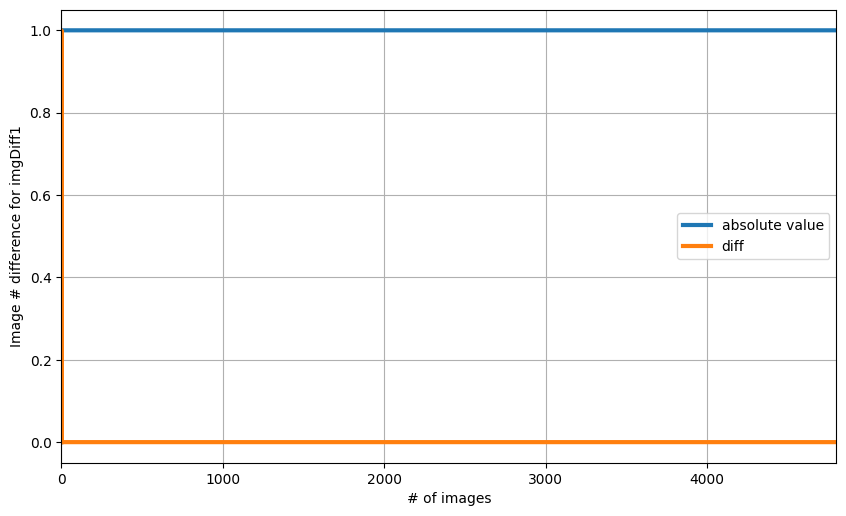

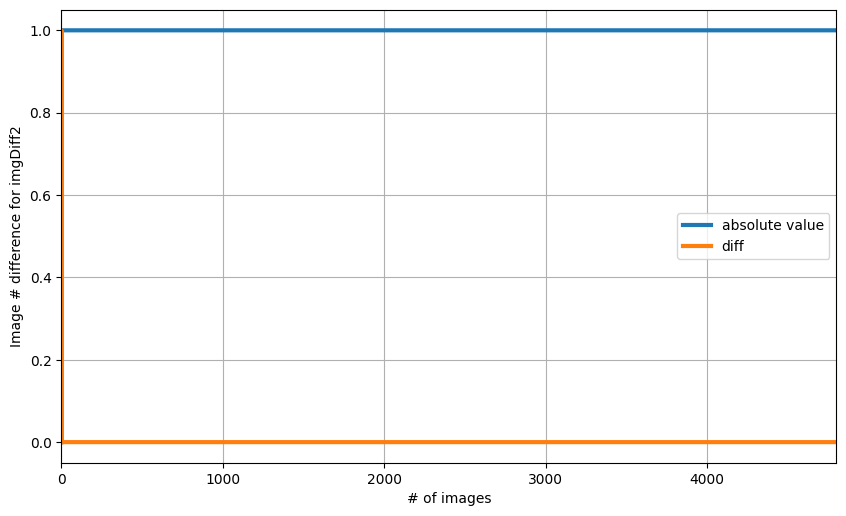

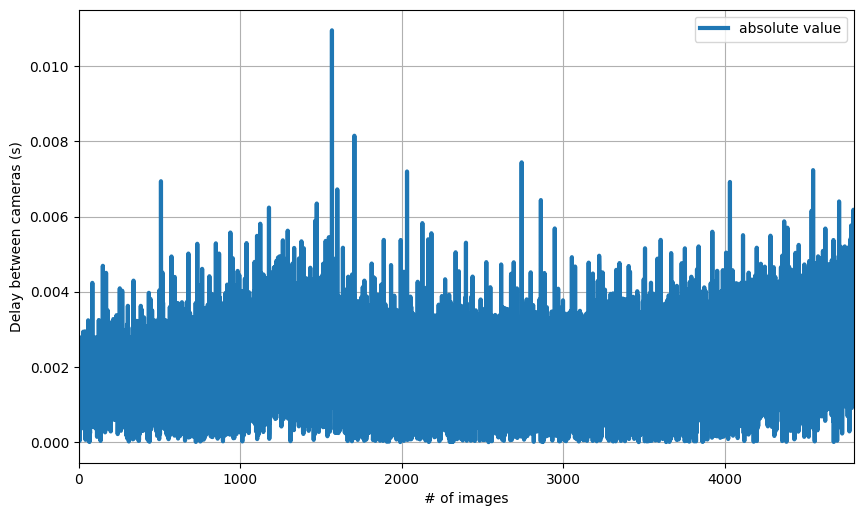

In [72]:
FPS = 40
maxDiff = 1/(FPS)/2
tresh = 10
windowLength = 10

# get valid iamges from csv timestamping
dfCam1 = pd.read_csv ('results_1.csv')    # read csv
dfCam2 = pd.read_csv ('results_2.csv')
dfCam1,dfCam2,columnsName,minLength = checkDatasets(dfCam1,dfCam2)

cam1_rows,cam2_rows,removeIdx = matchDatasets(dfCam1,dfCam2,columnsName,minLength,maxDiff,
                                                tresh,windowLength)

# get raw images path
rawCam1_Path = sorted(glob.glob("raw/camera1/*.jpg"))
rawCam2_Path = sorted(glob.glob("raw/camera2/*.jpg"))

# get clean slate for both cameras
bg1 = 'camera1.jpg'
bg2 = 'camera2.jpg'

# verbosity
verbose = 1

#select valid images
rawCam1_Path = np.array(rawCam1_Path)[cam1_rows]      
rawCam2_Path = np.array(rawCam2_Path)[cam2_rows] 

### Extracting centroids

In [78]:
# set counter for printable tracking
i = 0 
# create empy arrays for storing centers
centroidsCam1 = [0]
centroidsCam2 = [0]
# starting flags
noPrevious = 0
lastValid = 0
invalidIdx = []
cleanFolders()
map1_cam1, map2_cam1 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix_cam1, distCoef_cam1, np.eye(3), cameraMatrix_cam1, (640,480), cv2.CV_16SC2)
map1_cam2, map2_cam2 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix_cam2, distCoef_cam2, np.eye(3), cameraMatrix_cam2, (640,480), cv2.CV_16SC2)

print("------- Starting -------")
for i in range(0,len(rawCam1_Path),1):
    imgName1 = rawCam1_Path[i]
    # read img 2 name
    imgName2 = rawCam2_Path[i]
    text = imgName1.replace('raw/camera1\\', '', 1)
    # segment markers
    valid1,imgMasked1 = lowTreshSeg(imgName1,bg1,1)     
    valid2,imgMasked2 = lowTreshSeg(imgName2,bg2,2)     
    if not valid1 or not valid2:             
        print('Blobs in ' + text + ' cannot be identified. Discarded. ')
        if (i-lastValid) >= 10:
            nullPrev = 0
        invalidIdx.append(i)
        centroidsCam1 = np.vstack((centroidsCam1,np.zeros((3,2))))
        centroidsCam2 = np.vstack((centroidsCam2,np.zeros((3,2)))) 
    else:
        # find center                                  
        centerCoord1, valid1 = findBlobsCenter(imgName1,imgMasked1,cameraMatrix_cam1,distCoef_cam1,useFisheye)  
        centerCoord2, valid2 = findBlobsCenter(imgName2,imgMasked2,cameraMatrix_cam2,distCoef_cam2,useFisheye) 
        # check if they are linear
        if not valid1 or not valid2:             
            print('Blobs in ' + text + ' are not collinear. Discarded. ')
            if (i-lastValid) >= 10:
                nullPrev = 0
            invalidIdx.append(i)
            centroidsCam1 = np.vstack((centroidsCam1,np.zeros((3,2))))
            centroidsCam2 = np.vstack((centroidsCam2,np.zeros((3,2)))) 
        else:
            #get previous centroids
            prevCenterCoord1 = getPreviousCentroid(noPrevious, centroidsCam1[len(centroidsCam1)-3:(len(centroidsCam1))])
            prevCenterCoord2 = getPreviousCentroid(noPrevious, centroidsCam2[len(centroidsCam2)-3:(len(centroidsCam2))])
            # get sorted centers
            sortedCenterCoord1, otherCamOrder = orderCenterCoord(centerCoord1, prevCenterCoord1,map1_cam1, map2_cam1,imgName=imgName1, verbose=1)
            sortedCenterCoord2, _ = orderCenterCoord(centerCoord2, prevCenterCoord2,map1_cam2,map2_cam2,otherCamOrder,imgName2,1)
            if not noPrevious:
                centroidsCam1 = sortedCenterCoord1
                centroidsCam2 = sortedCenterCoord2
            else:
                centroidsCam1 = np.vstack((centroidsCam1, sortedCenterCoord1))  
                centroidsCam2 = np.vstack((centroidsCam2, sortedCenterCoord2))  
            # set flags
            noPrevious = 1
            lastValid = i
    if i % 100 == 0:                                                # tracking images processed
        print("Finished "+ str(i)+'/'+str(np.array(rawCam1_Path).shape[0]))
print("------- Finished -------")
print("Found 3 centroids in " + str(int(np.array(centroidsCam1).shape[0]/3-len(invalidIdx))) + ' images out of ' + str(int(np.array(centroidsCam1).shape[0]/3)))
print(str(len(invalidIdx))+' images were discarded.')

------- Starting -------
Finished 0/4801
Finished 100/4801
Finished 200/4801
Finished 300/4801
Finished 400/4801
Finished 500/4801
Finished 600/4801
Finished 700/4801
Finished 800/4801
Finished 900/4801
Finished 1000/4801
Finished 1100/4801
Finished 1200/4801
Finished 1300/4801
Finished 1400/4801
Finished 1500/4801
Finished 1600/4801
Finished 1700/4801
Finished 1800/4801
Finished 1900/4801
Finished 2000/4801
Blobs in raw/camera1/2037.jpg are not collinear. Discarded. 
Blobs in raw/camera1/2047.jpg are not collinear. Discarded. 
Finished 2100/4801
Finished 2200/4801
Finished 2300/4801
Finished 2400/4801
Finished 2500/4801
Finished 2600/4801
Finished 2700/4801
Finished 2800/4801
Finished 2900/4801
Finished 3000/4801
Finished 3100/4801
Finished 3200/4801
Finished 3300/4801
Finished 3400/4801
Finished 3500/4801
Finished 3600/4801
Finished 3700/4801
Finished 3800/4801
Finished 3900/4801
Finished 4000/4801
Finished 4100/4801
Finished 4200/4801
Finished 4300/4801
Finished 4400/4801
Blobs in r

In [79]:
use8norm = True
removeAllInvalid = np.copy(removeIdx)
if len(invalidIdx): removeAllInvalid = np.hstack((removeAllInvalid,np.array(invalidIdx)))
pts1 = np.delete(centroidsCam1.reshape(-1,3,2),removeAllInvalid,0).reshape(-1,2)
pts2 = np.delete(centroidsCam2.reshape(-1,3,2),removeAllInvalid,0).reshape(-1,2)

'''pts1 = np.copy(centroidsCam1.reshape(-1,3,2)).reshape(-1,2)
pts2 = np.copy(centroidsCam2.reshape(-1,3,2)).reshape(-1,2)'''

if use8norm:
    print("8-NORM")
    F,_ = estimateFundMatrix_8norm(pts1,pts2)
else: 
    F,mask = cv2.findFundamentalMat(pts1, pts2,method=cv2.RANSAC)
    print("\nRANSAC\nFund. Mat.\n", F.round(4))
    erroReprojection(F,np.vstack((pts1.T,np.ones((1,pts1.shape[0])))),
                   np.vstack((pts2.T,np.ones((1,pts2.shape[0])))))

E = np.matmul(cameraMatrix_cam2.T, np.matmul(F, cameraMatrix_cam1))
print("\nEssenc. Mat.\n", E.round(4))

#pts1 = pts1[mask.ravel()==1]
#pts2 = pts2[mask.ravel()==1]
R, t = decomposeEssentialMat(E, cameraMatrix_cam1, cameraMatrix_cam2, pts1, pts2)
P1 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]]))
P2 = np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))

projPt1 = myProjectionPoints(pts1)
projPt2 = myProjectionPoints(pts2)

points4d = cv2.triangulatePoints(P1.astype(float),
                                 P2.astype(float),
                                 projPt1.astype(float),
                                 projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T

if points3d[0, 2] < 0:
    points3d = -points3d

print("\nRot. Mat.\n", R.round(4))
print("\nTrans. Mat.\n", t.round(4))
savemat("points3d_final.mat", {'points3d': points3d})
savemat("points2d.mat", {'pts1': pts1,'pts2': pts2})

8-NORM
Fund. Mat.
 [[ 0.      0.     -0.0023]
 [ 0.     -0.     -0.0207]
 [-0.0012  0.0089  0.9997]]
avg x'Fx=0: 0.41318152082004084
max x'Fx=0: 2.0212613729121145

Essenc. Mat.
 [[  0.9538  11.3374   2.3043]
 [ 11.034   -1.1604 -10.0035]
 [  4.0649  11.6696  -0.3335]]

Rot. Mat.
 [[-0.0723 -0.214   0.9742]
 [ 0.3224  0.9193  0.2258]
 [-0.9438  0.3304  0.0026]]

Trans. Mat.
 [[-0.7138 -0.1869  0.6749]]


In [80]:
tot = 0
L_real_AC = 15.7
L_real_AB = 10.3
L_real_BC = 5.4
L_AC_vec = []
L_BC_vec = []
L_AB_vec = []
k = 0

for [A, B, C] in points3d.reshape([-1, 3, 3]):
    L_rec_AC = np.linalg.norm(A-C)
    L_rec_BC = np.linalg.norm(B-C)
    L_rec_AB = np.linalg.norm(A-B)
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
    tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
    k = k + 1

N = points3d.shape[0]
lamb = tot/N



### Results

Scale between real world and triang. point cloud is:  423.89
L_AC >> mean = 15.7032cm, std. dev = 0.174cm
L_AB >> mean = 10.313cm, std. dev = 0.129cm
L_BC >> mean = 5.3944cm, std. dev = 0.0642cm
Images distant more than 1% from the real value = 1824/4788


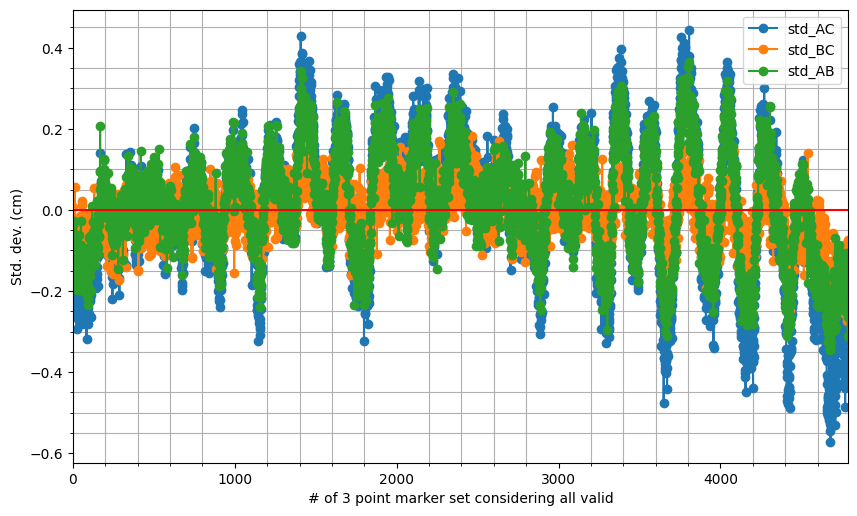

In [81]:
#cleanFolders()
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC
L_BC_vec_plot = np.array(L_BC_vec)*lamb - L_real_BC
L_AB_vec_plot = np.array(L_AB_vec)*lamb - L_real_AB
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("# of 3 point marker set considering all valid")
plt.ylabel("Std. dev. (cm)")
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(pts1)/3-1)

points3d_new = points3d*lamb
i = 0
for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
    L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
    valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
    if not valid:
        i = i + 1
print("Images distant more than 1% from the real value = " +
      str(i)+'/'+str(int(points3d.shape[0]/3)))

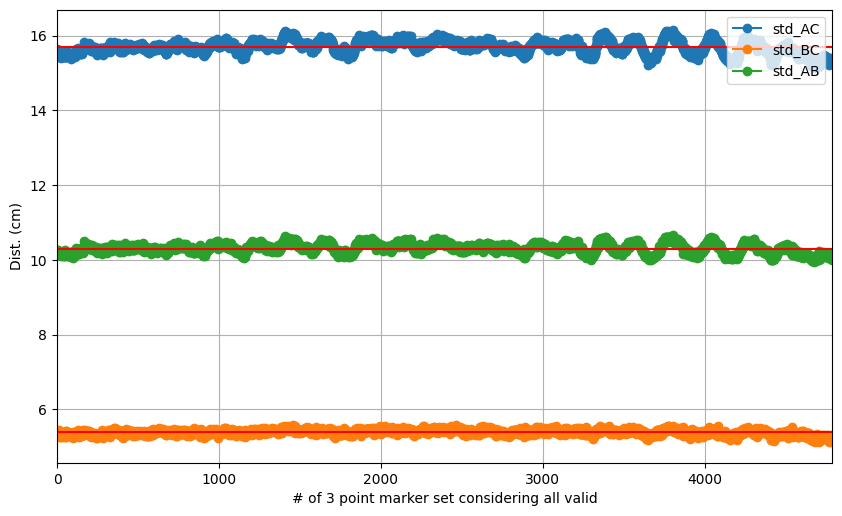

In [82]:
plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot = np.array(L_AC_vec)*lamb
L_BC_vec_plot = np.array(L_BC_vec)*lamb
L_AB_vec_plot = np.array(L_AB_vec)*lamb
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.axhline(y=L_real_AC, color='r', linestyle='-')
plt.axhline(y=L_real_BC, color='r', linestyle='-')
plt.axhline(y=L_real_AB, color='r', linestyle='-')
plt.xlim(0,len(pts1)/3-1)
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("# of 3 point marker set considering all valid")
plt.ylabel("Dist. (cm)")
plt.legend()


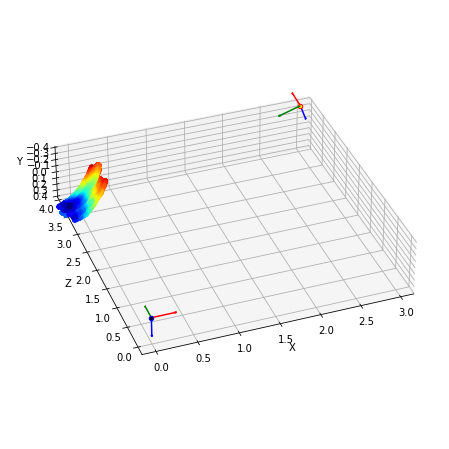

In [83]:
savemat("dataRTLamb.mat", {'R': R, 't': t, 'lamb': lamb})

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlim(-0.1, 3.1)
ax.set_zlim(-0.4, 0.4)
ax.set_ylim(-0.1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

scale = 0.3
ax.quiver(0, 0, 0, scale, 0, 0,  # x0,y0,z0,x1,y1,z1
          arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(0, 0, 0, 0, 0, scale,
          arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(0, 0, 0, 0, scale, 0,
          arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(0, 0, 0, edgecolor="blue", facecolor="black")

x = np.array([scale, 0, 0])
y = np.array([0, scale, 0])
z = np.array([0, 0, scale])
x = np.matmul(R.T, x)
y = np.matmul(R.T, y)
z = np.matmul(R.T, z)

t_aux = np.matmul(-t, R)*lamb/100

ax.quiver(t_aux[0][0], t_aux[0][2], t_aux[0][1],
          x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(t_aux[0][0], t_aux[0][2], t_aux[0][1],
          y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(t_aux[0][0], t_aux[0][2], t_aux[0][1],
          z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(t_aux[0][0], t_aux[0][2], t_aux[0][1],
           edgecolor="r", facecolor="gold")

cmhot = plt.get_cmap("jet")

#ax.view_init(elev=0, azim=-90)  # -37.5,30
#ax.view_init(elev=-70, azim=-120)  # -37.5,30
ax.view_init(elev=35, azim=-110)  # -37.5,30
ax.scatter(points3d[:, 0]*lamb/100, points3d[:, 2]*lamb/100,
           points3d[:, 1]*lamb/100, c=points3d[:, 2], cmap=cmhot)
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .3, 1.]))
